<a href="https://colab.research.google.com/github/juancn95/saturdaysAI_titanic_challenge/blob/pdt_1/LPM_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Preambulo 

El hundimiento del RMS Titanic es uno de los naufragios más infames de la historia. El 15 de abril de 1912, durante su viaje inaugural, el Titanic se hundió después de chocar con un iceberg, matando a 1502 de los 2224 pasajeros y tripulación. Esta sensacional tragedia conmocionó a la comunidad internacional y condujo a mejores regulaciones de seguridad para los barcos.

Una de las razones por las que el naufragio provocó tal pérdida de vidas fue que no había suficientes botes salvavidas para los pasajeros y la tripulación. Aunque hubo algún elemento de suerte en la supervivencia del hundimiento, algunos grupos de personas tenían más probabilidades de sobrevivir que otros, como las mujeres, los niños y la clase alta.

En este desafío, les pedimos que completen el análisis de qué tipo de personas tenían probabilidades de sobrevivir. En particular, le pedimos que aplique las herramientas del aprendizaje por máquina para predecir qué pasajeros sobrevivieron a la tragedia.

### 1.1 Objetivo
* Con los datos del historial Predecir si un de pasajeros sobrevivió (1) o no (0), tras el hundimiento del Titanic

### 1.2 Métrica
La puntuación del modelo será el porcentaje de pasajeros correctamente predecidos, conocido también como precisión.

### 1.3 Formato del archivo de entrega
El formato será un archivo de extensión .csv con 418 entradas con su correspondiente fila de encabezado, y solo deberá contener las columnas PassengerID y Survived. Si el archivo tiene una columna o fila extra, se remitirá un error.

**PassengerID**: Ordenado en cualquier orden, sea ascendente o descendente.
**Survived**: Contiene la predicción binaria: 1 para sobrevivió, 0 para fallecido.

# 2. Librerías y ruta de los datos

In [298]:
! pip3 install -U cmocean
! pip3 install -U matplotlib

Requirement already up-to-date: cmocean in /usr/local/lib/python3.6/dist-packages (2.0)
Requirement already up-to-date: matplotlib in /usr/local/lib/python3.6/dist-packages (3.2.1)


In [0]:
#Análisis
import pandas as pd
import numpy as np

#Visualización
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
import cmocean.cm as cmo

#Preparación
from sklearn.pipeline import Pipeline
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

#Optimización
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, learning_curve
from sklearn.feature_selection import SelectFromModel
from scipy.stats import randint
import itertools
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score

#Redes neuronales
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, AlphaDropout
from tensorflow.keras.optimizers import SGD, RMSprop, Adamax, Adagrad, Adam, Nadam, SGD

import warnings 
warnings.filterwarnings("ignore") 

path_train = 'https://saturday-ai.s3-sa-east-1.amazonaws.com/titanic/train.csv';
path_test = 'https://saturday-ai.s3-sa-east-1.amazonaws.com/titanic/test.csv';
path_submission = 'https://saturday-ai.s3-sa-east-1.amazonaws.com/titanic/gender_submission.csv';

In [190]:
#Carga de datos a dataframes
df_train = pd.read_csv(path_train, sep=',', na_values="?");
df_test = pd.read_csv(path_test, sep=',', na_values="?");

'''Como vamos a trabajar con dos conjuntos de datos, es necesario agruparlos para aplicar las reglas en común'''
df_data = pd.concat([df_train, df_test], axis=0, ignore_index=True)
df_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


# 3. Revisar los datos 

In [191]:
print('Hay {} observaciones y {} variables'.format(df_data.shape[0], df_data.shape[1]), '\n')
df_data.info()

Hay 1309 observaciones y 12 variables 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [192]:
#Revisemos si existen datos perdido
df_data.isna().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

Sin tomar en cuenta la variable **Survived** se tiene que hay datos perdidos, en las variables **Age, Fare, Cabin y Embarked**.

Ahora evaluemos los datos numéricos, para determiar si hay Datos Atípicos

In [193]:
df_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


El valor máximo y mínicmo en **Fare** se debería evaluar. Hubo pasajes gratis y otros muy caros?

#### Ahora evaluemos la correlación que existe entre las Features con la variable objetivo

In [194]:
df_train.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


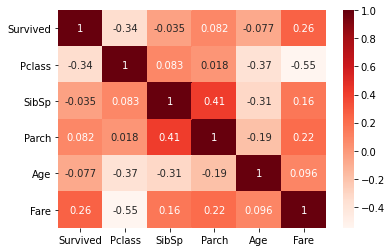

In [195]:
#Vemos lo mismo pero de manera gráfica. Quitamos PassengerId, porque no da valor a la evaluación
sb.heatmap(df_train[["Survived","Pclass","SibSp","Parch","Age","Fare"]].corr(), cmap = "Reds", annot=True)

Podemos notar que la variable mas correlacionada es **Fare**, esto podría explicarse porque los ricos estaban en las cabinas altas.

También hay que evaluar la Edad y Sexo, pues de esto también dependía quienes eran los primeros en subir a los botes salvavidas

# 4. Evaluación de variables

### Evaluación de Pclass, 1: 1st, 2: 2nd, 3: 3rd

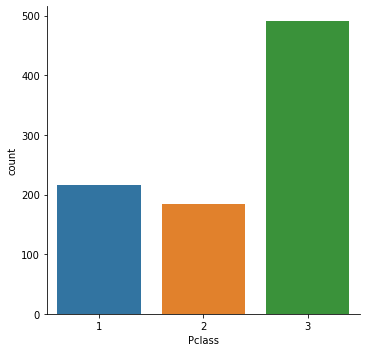

In [196]:
sb.catplot(data=df_train, x="Pclass", kind="count")

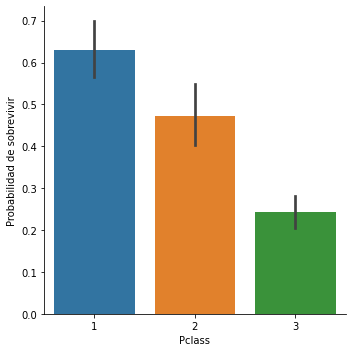

In [197]:
sb.catplot(data=df_train, x="Pclass", y="Survived", kind="bar").set_ylabels("Probabilidad de sobrevivir")

Notamos que esta variable es importante en el modelo, pues la probabilidad de sobrevivencia de la clase Alta, es mayor

### Evaluación de Sex

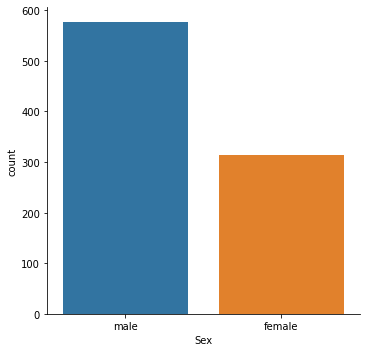

In [198]:
sb.catplot(data=df_train, x="Sex", kind="count")

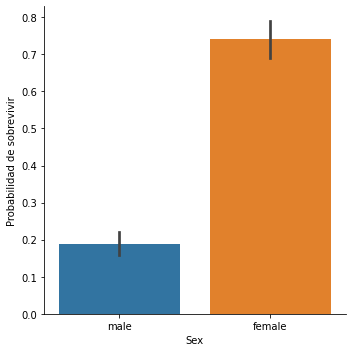

In [199]:
sb.catplot(data=df_train, x="Sex", y="Survived", kind="bar").set_ylabels("Probabilidad de sobrevivir")

Claramente la probabilidad de sobrevivir, dado que es mujer es mayor que ser hombre. 

Evaluemos también como se relaciona la variable Sex, y Pclass. Allí vemos que las mujeres siendo de Tercera Clase, sobreviven menos de la mitad

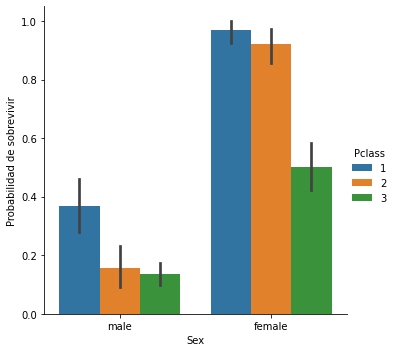

In [200]:
sb.catplot(data=df_train, x="Sex", y="Survived", hue="Pclass", kind="bar").set_ylabels("Probabilidad de sobrevivir")

### Evaluación de Age
Se hace la evaluación tomando grupos de edades

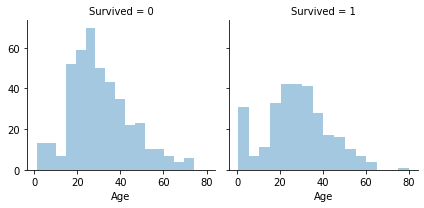

In [201]:
# Revisemos como se comportan los datos No vivos / Vivos
sb.FacetGrid(data=df_train, col='Survived').map(sb.distplot, "Age", kde=False)

Se puede notar claramente que los niños, incluso adolescentes tienen mas probabilidad de sobrevivir. A lo cual se va a crear una nueva variable categórica indicando los "Jóvenes y Adultos"

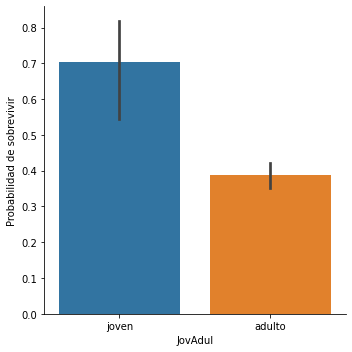

In [248]:
df_train["JovAdul"]= pd.cut(df_train["Age"], bins=[0,5,max(df_train["Age"]+1)], labels=['joven','adulto'])
#Revisamos de igual manera la probabilidad de sobrevivir con esta nueva variable
sb.catplot(data=df_train, x="JovAdul", y="Survived", kind="bar").set_ylabels("Probabilidad de sobrevivir")

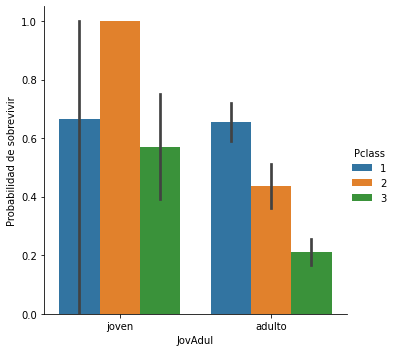

In [249]:
# Evaluemos también como se comporta con la clase social
sb.catplot(data=df_train, x="JovAdul", y="Survived", hue="Pclass", kind="bar").set_ylabels("Probabilidad de sobrevivir")

Un dato curioso. Los jóvenes de segunda clase, sobrevivieron igual que los de primera clase, o puede que no habían muchos jóvenes de primera clase

### Evaluación de SibSp (Siblings/Spouse)

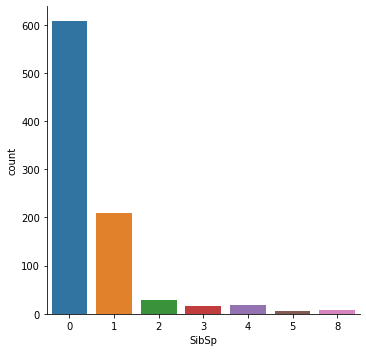

In [250]:
sb.catplot(data=df_train, x="SibSp", kind="count")

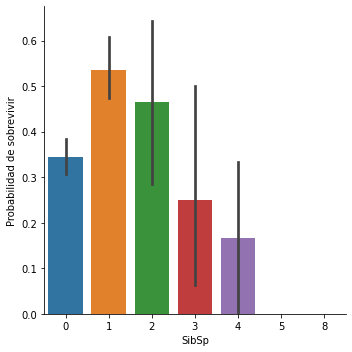

In [251]:
sb.catplot(data=df_train, x="SibSp", y="Survived", kind="bar").set_ylabels("Probabilidad de sobrevivir")

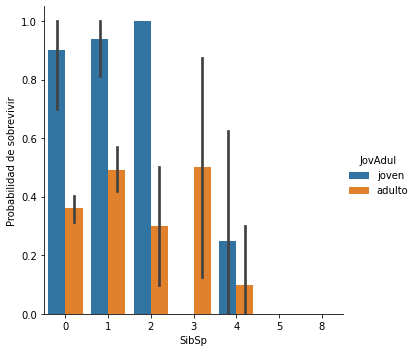

In [252]:
# Number of passengers with no or several Siblings/Spouses
sb.catplot(data=df_train, x="SibSp", y="Survived", hue='JovAdul',kind="bar").set_ylabels("Probabilidad de sobrevivir")

Podemos comprobar primero que la probabilidad de sobrevivencia de las personas que tenían hijos es mayor, directamente relacionado si este era jóven

### Evaluación de Parch (Parents/children)
La mayor parte no tiene ni padres ni hijos

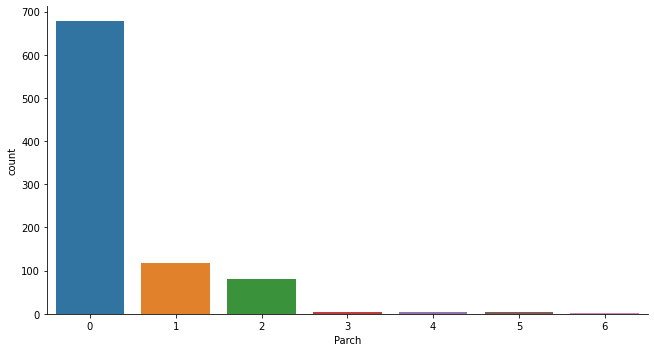

In [329]:
sb.catplot(data=df_train, x="Parch", kind="count", aspect=1.8*1)

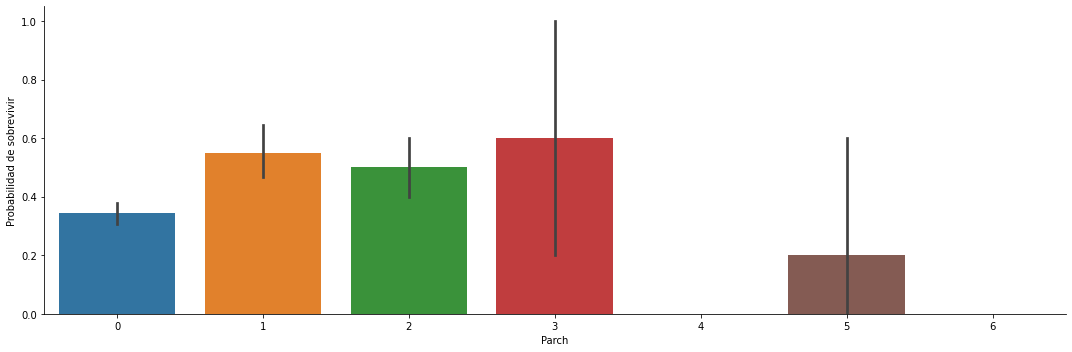

In [314]:
sb.catplot(data=df_train, x="Parch", y="Survived", kind="bar", aspect=1.5*2).set_ylabels("Probabilidad de sobrevivir")

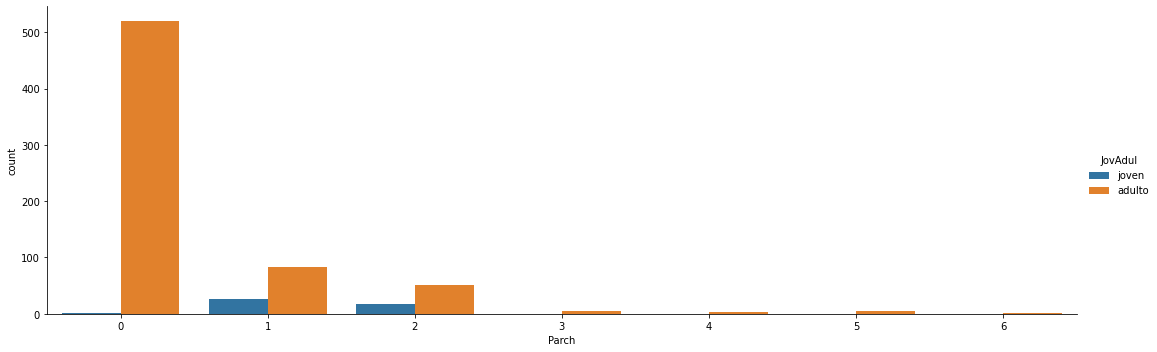

In [330]:
#Gráfica para determinar hijos sin, o con varios padres 
sb.catplot(data=df_train, x="Parch", hue='JovAdul', kind="count", aspect=3)

**Resumen**: La probabilidad de que un pasajero sobreviva es mayor si pertenece a una familia más pequeña en lugar de viajar solo (adulto) o de pertenecer a una familia grande (más de 3 SibSp o Parch). Debemos considerar todo esto

### Evaluación de Fare
La matriz de correlación que hemos analizado anteriormente mostró que Fare tiene una fuerte correlación con la posibilidad de sobrevivir. Exploremos la distribución de las tarifas y cómo se correlaciona con la supervivencia.

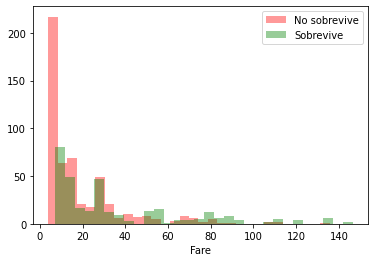

In [331]:
## Para entender mejor la parte de tarifas aplicadas
kde = False
upper = 150 
lower = 0    
Pclass = 0   # 0, para todas las clases

bins=int((upper-lower)/5) 
if Pclass == 1 or Pclass == 2 or Pclass == 3:
    upPclass = Pclass+1
    lowPclass = Pclass
else: 
    upPclass = 4
    lowPclass = 1
    
plt = sb.distplot(df_train["Fare"][(df_train["Survived"] == 0) & (df_train["Fare"]< upper) & (df_train["Fare"]> lower) & (df_train["Pclass"]<upPclass) & (df_train["Pclass"]>=lowPclass)], bins=bins, color="Red", kde=kde)
plt = sb.distplot(df_train["Fare"][(df_train["Survived"] == 1) & (df_train["Fare"]< upper) & (df_train["Fare"]> lower) & (df_train["Pclass"]<upPclass) & (df_train["Pclass"]>=lowPclass)], bins=bins, color="Green", kde=kde)
plt.set_xlabel("Fare")
plt = plt.legend(["No sobrevive","Sobrevive"])

Encontramos algo atípico. Algunos pasajes de tercera clase son mas caros que de primera clase.

In [332]:
df_data[['Fare','Name','Ticket','SibSp','Parch']].iloc[df_data.index[(df_data['Pclass']==3) & (df_data['Fare']>60)]]

,Fare,Name,Ticket,SibSp,Parch
159,69.55,"Sage, Master. Thomas Henry",CA. 2343,8,2
180,69.55,"Sage, Miss. Constance Gladys",CA. 2343,8,2
201,69.55,"Sage, Mr. Frederick",CA. 2343,8,2
324,69.55,"Sage, Mr. George John Jr",CA. 2343,8,2
792,69.55,"Sage, Miss. Stella Anna",CA. 2343,8,2
846,69.55,"Sage, Mr. Douglas Bullen",CA. 2343,8,2
863,69.55,"Sage, Miss. Dorothy Edith ""Dolly""",CA. 2343,8,2
1079,69.55,"Sage, Miss. Ada",CA. 2343,8,2
1233,69.55,"Sage, Mr. John George",CA. 2343,1,9
1251,69.55,"Sage, Master. William Henry",CA. 2343,8,2


Se nota que los precios altos, se debe a que los pasajes están por toda una familia. Esto es un problema. Entonces trabajemos en crear una nueva variable que indique los costos por separado

In [259]:
# Desviar los valores altos por el número de personas
df_train['FarePers'] = df_train['Fare'].copy()

m = 0
for grp, grp_df in df_train[['Ticket', 'Name', 'Pclass', 'Fare', 'PassengerId']].groupby(['Ticket']):
    if (len(grp_df) != 1):
        if m==0:
            print(grp_df)
            m=1
        for ind, row in grp_df.iterrows():
            passID = row['PassengerId']
            df_train.loc[df_train['PassengerId'] == passID, 'FarePers'] = df_train['Fare'][df_train['PassengerId'] == passID]/len(grp_df)
            

     Ticket  ... PassengerId
257  110152  ...         258
504  110152  ...         505
759  110152  ...         760

[3 rows x 5 columns]


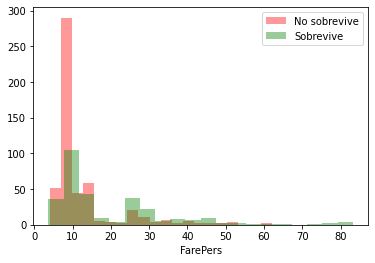

In [260]:
## Volvemos a aplicar, pero con la nueva variable
kde = False
upper = 100
lower = 0    
Pclass = 0   # 0, para todas las clases

bins=int((upper-lower)/5) 
if Pclass == 1 or Pclass == 2 or Pclass == 3:
    upPclass = Pclass+1
    lowPclass = Pclass
else: 
    upPclass = 4
    lowPclass = 1
    
plt = sb.distplot(df_train["FarePers"][(df_train["Survived"] == 0) & (df_train["Fare"]< upper) & (df_train["FarePers"]> lower) & (df_train["Pclass"]<upPclass) & (df_train["Pclass"]>=lowPclass)], bins=bins, color="Red", kde=kde)
plt = sb.distplot(df_train["FarePers"][(df_train["Survived"] == 1) & (df_train["Fare"]< upper) & (df_train["FarePers"]> lower) & (df_train["Pclass"]<upPclass) & (df_train["Pclass"]>=lowPclass)], bins=bins, color="Green", kde=kde)
plt.set_xlabel("FarePers")
plt = plt.legend(["No sobrevive","Sobrevive"])

Haciendo esto, normalizamos la información. Con lo cual se nota que las personas que compraron un pasaje caro, tienen mas probabilidad de sobrevivir.

Vamoa a crear una nueva variable para categorizar según el valor del boleto

In [261]:
df_train['FareCat'] = pd.cut(df_train['FarePers'], bins=[0,15,65,max(df_train["FarePers"]+1)], labels=['bajo','medio','alto'])
df_train['FareCat'].value_counts()

bajo     618
medio    227
alto      31
Name: FareCat, dtype: int64

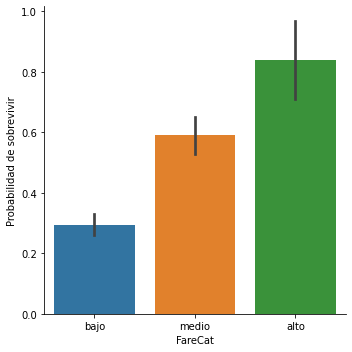

In [262]:
sb.catplot(data=df_train, x="FareCat", y="Survived", kind="bar").set_ylabels("Probabilidad de sobrevivir")

Con esto conseguimos normalizar y entender mejor esta varaiable

### Evaluación de Embarked

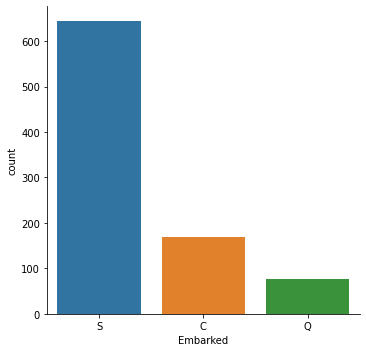

In [263]:
sb.catplot(data=df_train, x="Embarked", kind="count")

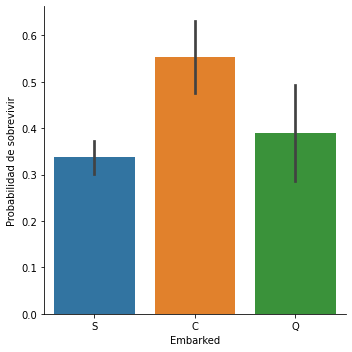

In [264]:
sb.catplot(data=df_train, x="Embarked", y="Survived", kind="bar").set_ylabels("Probabilidad de sobrevivir")

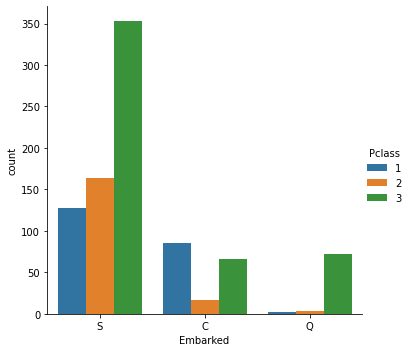

In [265]:
#Se evalua también el total de ingresos, por clase social
sb.catplot(x="Embarked", hue='Pclass',kind="count", data=df_train)

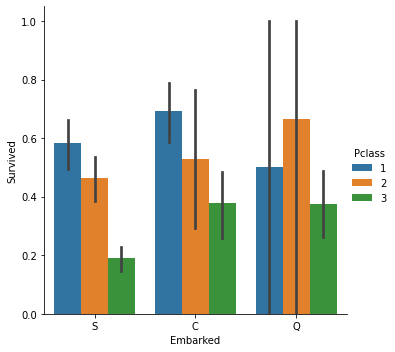

In [266]:
sb.catplot(x="Embarked", y='Survived', hue='Pclass', kind="bar", data=df_train)

La mayoría de los pasajeros embarcaron en Southampton - una mitad en tercera clase, la otra mitad en primera y segunda clase. La mayoría de los pasajeros que embarcaron en Cherburgo viajaron en 1ª clase, lo que explica la mayor probabilidad de supervivencia de este grupo de pasajeros. Es notable que en Queenstwon embarcaron principalmente pasajeros de 3ª clase, sin embargo, su probabilidad de supervivencia es mayor que la de los pasajeros que embarcaron en Southamton

**NOTA:** La variable Cabin no será evaluada, dato que con los datos de ticket se puede evaluarlas, Además que hay muchos datos perdidos

# 5. Nuevas características y valores perdidos

In [267]:
# Vamos a agregar una nueva característica, el título de cada persona
for name in df_data['Name']:
    df_data['Title'] = df_data['Name'].str.extract('([A-Za-z]+)\.', expand=True)

df_data['Title'] = df_data['Title'].replace({'Ms':'Miss','Mlle':'Miss','Mme':'Mrs'})

df_data['Title'].value_counts()

Mr          757
Miss        264
Mrs         198
Master       61
Rev           8
Dr            8
Col           4
Major         2
Capt          1
Dona          1
Don           1
Countess      1
Jonkheer      1
Lady          1
Sir           1
Name: Title, dtype: int64

In [268]:
# Agrupamos en menos categorias
df_data['Title'] = df_data['Title'].replace(['Sir','Don','Dona','Jonkheer','Lady','Countess'], 'Noble')

df_data['Title'] = df_data['Title'].replace(['Dr', 'Rev','Col','Major','Capt'], 'Others')

df_data['Title'].value_counts()

Mr        757
Miss      264
Mrs       198
Master     61
Others     23
Noble       6
Name: Title, dtype: int64

### TRabajo con la variable edad
La estrategia a tomar será en categorizarla, de igual manera como se hizo en el análisis

In [269]:
df_data.groupby('Title')['Age'].median()

Title
Master     4.0
Miss      23.0
Mr        29.0
Mrs       35.0
Noble     39.5
Others    49.5
Name: Age, dtype: float64

In [270]:
# Evaluamos las diferencias que se tienen de las mujeres jóvenes y adultas
# Evaluamos esto, dado que la probabilidad de sobrevivencia en las mujeres es mayor
print('Promedio de edad joven Miss(age<16): '+ str(df_data['Age'][(df_data['Title']== 'Miss') & (df_data['Age']<16)].median()) + ' años')
print('Promedio de edad adulta Miss (age>=16): '+ str(df_data['Age'][(df_data['Title']== 'Miss') & (df_data['Age']>=16)].median()) + ' años')

Promedio de edad joven Miss(age<16): 5.0 años
Promedio de edad adulta Miss (age>=16): 24.0 años


In [0]:
#Agregamos una nueva categoría con esta observación, jovenMiss
title_list=df_data.groupby('Title')['Age'].median().index.to_list()

for title in title_list:
    if title=='Miss':
        df_data.loc[(df_data['Age'].isnull()) & (df_data['Title'] == title) & (df_data['Parch'] == 0), 'Age'] = df_data['Age'][(df_data['Title']== title) & (df_data['Age']>=16)].median()
        
        df_data.loc[(df_data['Age'].isnull()) & (df_data['Title'] == title) & (df_data['Parch'] > 0), 'Age'] = df_data['Age'][(df_data['Title']== title) & (df_data['Age']<16)].median()
        
        df_data.loc[(df_data['Age']<15) & (df_data['Title'] == title), 'Title'] = 'jovenMiss'                                                 
    else: 
        df_data.loc[(df_data['Age'].isnull()) & (df_data['Title'] == title), 'Age'] = df_data['Age'][(df_data['Title']== title)].median()


In [272]:
print(df_data['Title'].value_counts())
df_data.groupby('Title')['Age'].median()

Mr           757
Miss         204
Mrs          198
Master        61
jovenMiss     60
Others        23
Noble          6
Name: Title, dtype: int64


Title
Master        4.0
Miss         24.0
Mr           29.0
Mrs          35.0
Noble        39.5
Others       49.5
jovenMiss     5.0
Name: Age, dtype: float64

In [273]:
## Dividimos la característica Age en 5 categorías, donde la categoría 1 se refiere a los niños (edad<16)
df_data["AgeCat"] = pd.cut(df_data["Age"], bins=[0,14.9,30,45,60,max(df_data["Age"]+1)], labels=['1','2','3','4','5'])

df_data['AgeCat'].value_counts()

2    717
3    309
1    127
4    123
5     33
Name: AgeCat, dtype: int64

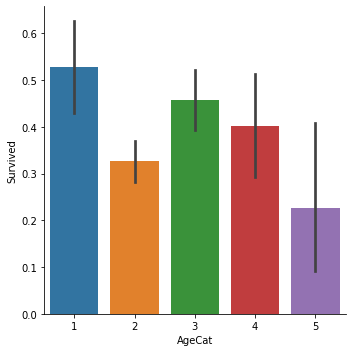

In [274]:
sb.catplot(data=df_data[:len(df_train)], x='AgeCat', y='Survived', kind='bar')

### Trabajo con la Variable SibSp y Parch
La idea aqui, es categorizar estas variables usando un identificador del tamaño de la familia. En el análisis anteriro vimos que las familias pequeñas tenían mas probabilidad de sobrevivir

Single    790
Small     437
Big        82
Name: TamanoFamilia, dtype: int64


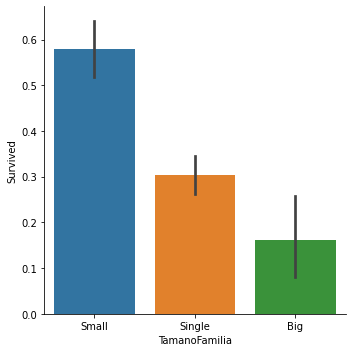

In [275]:
df_data.loc[df_data['SibSp'] + df_data['Parch'] + 1 == 1, 'TamanoFamilia'] = 'Single'
df_data.loc[df_data['SibSp'] + df_data['Parch'] + 1 > 1 , 'TamanoFamilia'] = 'Small'
df_data.loc[df_data['SibSp'] + df_data['Parch'] + 1 > 4 , 'TamanoFamilia'] = 'Big'

print( df_data.TamanoFamilia.value_counts() )
sb.catplot(data=df_data[:len(df_train)], x='TamanoFamilia', y='Survived', kind='bar')

### Agregar variable FarePers and FareCat
Siguiendo la estrategia de categorizar todo, haremos lo mismo con **Fare**, según la evaluación anterior realizada

In [276]:
df_data['FarePers'] = df_data['Fare'].copy()

for grp, grp_df in df_data[['Ticket','Name', 'Pclass', 'Fare', 'PassengerId']].groupby(['Ticket']):

    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            passID = row['PassengerId']
            df_data.loc[df_data['PassengerId'] == passID, 'FarePers'] = df_data['Fare'][df_data['PassengerId'] == passID]/len(grp_df)
          
#ADemás completamos los valores que estaban perdidos, tomando como premisa la clase 3
fare_temp = df_data[df_data["Pclass"] == 3]
df_data['FarePers'].fillna(fare_temp['FarePers'].median(), inplace = True)
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   PassengerId    1309 non-null   int64   
 1   Survived       891 non-null    float64 
 2   Pclass         1309 non-null   int64   
 3   Name           1309 non-null   object  
 4   Sex            1309 non-null   object  
 5   Age            1309 non-null   float64 
 6   SibSp          1309 non-null   int64   
 7   Parch          1309 non-null   int64   
 8   Ticket         1309 non-null   object  
 9   Fare           1308 non-null   float64 
 10  Cabin          295 non-null    object  
 11  Embarked       1309 non-null   object  
 12  Title          1309 non-null   object  
 13  AgeCat         1309 non-null   category
 14  TamanoFamilia  1309 non-null   object  
 15  FarePers       1309 non-null   float64 
 16  FareCat        1309 non-null   category
dtypes: category(2), float64(4), int64

In [277]:
# Vamos a subdividir en 7 categorías
df_data['FareCat'] = pd.qcut(df_data['FarePers'], 7, labels=['1','2','3','4','5','6','7'])
df_data['FareCat'].value_counts()

2    236
5    212
1    188
7    186
4    167
6    162
3    158
Name: FareCat, dtype: int64

### Trabajar con los valores perdidos de Embarked
Se decide hacer que todos los faltantes embarcaron en "C"

In [278]:
df_data['Embarked'].fillna('C', inplace = True)
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   PassengerId    1309 non-null   int64   
 1   Survived       891 non-null    float64 
 2   Pclass         1309 non-null   int64   
 3   Name           1309 non-null   object  
 4   Sex            1309 non-null   object  
 5   Age            1309 non-null   float64 
 6   SibSp          1309 non-null   int64   
 7   Parch          1309 non-null   int64   
 8   Ticket         1309 non-null   object  
 9   Fare           1308 non-null   float64 
 10  Cabin          295 non-null    object  
 11  Embarked       1309 non-null   object  
 12  Title          1309 non-null   object  
 13  AgeCat         1309 non-null   category
 14  TamanoFamilia  1309 non-null   object  
 15  FarePers       1309 non-null   float64 
 16  FareCat        1309 non-null   category
dtypes: category(2), float64(4), int64

# 6. Preparación de los datos

In [0]:
#Borramos las variables que no se van a usar
df_data_fin = df_data.drop(['Survived','PassengerId','Name','Age','Parch','SibSp','Ticket','Fare','Cabin','FarePers'],axis=1)

In [280]:
df_data_fin

,Pclass,Sex,Embarked,Title,AgeCat,TamanoFamilia,FareCat
0,3,male,S,Mr,2,Small,2
1,1,female,C,Mrs,3,Small,7
2,3,female,S,Miss,2,Single,3
3,1,female,S,Mrs,3,Small,6
4,3,male,S,Mr,3,Single,4
...,...,...,...,...,...,...,...
1304,3,male,S,Mr,2,Single,4
1305,1,female,C,Noble,3,Single,7
1306,3,male,S,Mr,3,Single,2
1307,3,male,S,Mr,2,Single,4


In [281]:
# A continuación vamos a normalizar las variables, tanto categóricas como numéricas
cat_atributo = list( df_data_fin.columns)

# Declaración para usar la normalización en variables categóricas
oneHot = OneHotEncoder()
df_data_post = oneHot.fit_transform(df_data_fin[cat_atributo])

#Revisemos las columnas generadas
oneHot.get_feature_names(df_data_fin.columns)


array(['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Noble',
       'Title_Others', 'Title_jovenMiss', 'AgeCat_1', 'AgeCat_2',
       'AgeCat_3', 'AgeCat_4', 'AgeCat_5', 'TamanoFamilia_Big',
       'TamanoFamilia_Single', 'TamanoFamilia_Small', 'FareCat_1',
       'FareCat_2', 'FareCat_3', 'FareCat_4', 'FareCat_5', 'FareCat_6',
       'FareCat_7'], dtype=object)

### Vamos ahora a dividir para entrenar
Ya era hora

In [0]:
# Datos Para el entrenamiento
X_train = df_data_post[:len(df_train['Survived']),:].toarray()
y_train = df_train['Survived'].copy().to_numpy()

# Datos para las pruebas
X_test = df_data_post[len(df_train['Survived']):,:].toarray()

### Funciones y modelos para evaluar y entrenar
--- Código gracias a @Dante346 https://github.com/dante346

In [0]:
# define functions
def hyperparameter_analysis(searcher, top_values=5):
    tested_hyperparameters=pd.DataFrame()
    for i in range(len(searcher.cv_results_['params'])):
        tested_hyperparameters = tested_hyperparameters.append(searcher.cv_results_['params'][i], ignore_index=True)
    tested_hyperparameters['train score in %']=(searcher.cv_results_['mean_train_score']*100).round(3)
    tested_hyperparameters['test score in %']=(searcher.cv_results_['mean_test_score']*100).round(3)
    tested_hyperparameters['test std in %']=(searcher.cv_results_['std_test_score']*100).round(3)
    tested_hyperparameters.index=searcher.cv_results_['rank_test_score']
    return(tested_hyperparameters.sort_index().head(top_values))

def feature_importance(searcher_best_estimator, list_feature_names, top_values=5):
    # calculate normed feature_importances
    fi_norm = 1/abs(searcher_best_estimator.feature_importances_).sum()*abs(searcher_best_estimator.feature_importances_)
    # create DataFrame 
    fi_df= pd.DataFrame(data=(fi_norm*100).round(2), index=list_feature_names, columns=['feature importance in %'])
    return(fi_df.sort_values(['feature importance in %'], ascending=[False]).head(top_values))

def feature_importance_ann(perm, list_feature_names, top_values=5, neg_values=False):    
    if neg_values==True:
        fi_df= pd.DataFrame(data=(perm.feature_importances_*100).round(2), index=list_feature_names, columns=['score reduction in % points'])
        return(fi_df[fi_df['score reduction in % points']<0]).sort_values(['score reduction in % points'], ascending=[True]).head(top_values)
    else:    
        fi_df= pd.DataFrame(data=(perm.feature_importances_*100).round(2), index=list_feature_names, columns=['score reduction in % points'])
        return(fi_df.sort_values(['score reduction in % points'], ascending=[False]).head(top_values))

def metric_scores(y_reference, y_prediction):
    precision = precision_score(y_reference, y_prediction)
    recall = recall_score(y_reference, y_prediction)
    F1_score = f1_score(y_reference, y_prediction)
    print('precision: '+ str(precision.round(3)))
    print('recall: '+ str(recall.round(3)))
    print('F1_score: '+ str(F1_score.round(3)))
    return(precision, recall, F1_score)

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=cmo.matter_r):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def pred_to_df(y_predicted):
    survived = pd.DataFrame(y_predicted,index=test.index, columns=['Survived'])
    survived['PassengerId'] = test.PassengerId 
    columns_titles = ["PassengerId","Survived"]
    survived=survived.reindex(columns=columns_titles)
    return(survived)

def save_to_csv(survived, filename,index=False):
    survived.to_csv(filename + '.csv',index=False, header=survived.columns)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

### Definición del modelo

In [0]:
def create_model(input_shape=X_train.shape[1:], number_hidden=2, neurons_per_hidden=10, hidden_drop_rate= 0.2,
                hidden_activation = 'relu', hidden_initializer="lecun_normal", output_activation ='sigmoid',
                loss='binary_crossentropy', optimizer = Adamax(lr=0.0005),
                ):
    
    #Definicion del modelo 
    model = Sequential()
    model.add(Input(shape=input_shape)),
    for layer in range(number_hidden):
        model.add(Dense(neurons_per_hidden, activation = hidden_activation ,kernel_initializer=hidden_initializer))
        model.add(Dropout(hidden_drop_rate))
    model.add(Dense(1, activation = output_activation))

    # Compile model
    model.compile(loss=loss, 
                  #optimizer = Nadam(lr=lr), 
                  optimizer = Nadam(lr=0.0005),
                  metrics = ['accuracy'])
    return model

### Compilar el modelo clasificador

In [285]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

dnn_clf = create_model()

# Entrenamiento
history = dnn_clf.fit(X_train, y_train, epochs=60, batch_size=30, verbose=1, validation_split=0.2)

Epoch 1/60
24/24 [==============================] - 0s 7ms/step - loss: 0.6817 - accuracy: 0.5772 - val_loss: 0.6666 - val_accuracy: 0.6480
Epoch 2/60
24/24 [==============================] - 0s 5ms/step - loss: 0.6640 - accuracy: 0.6110 - val_loss: 0.6474 - val_accuracy: 0.6480
Epoch 3/60
24/24 [==============================] - 0s 4ms/step - loss: 0.6480 - accuracy: 0.6081 - val_loss: 0.6300 - val_accuracy: 0.6536
Epoch 4/60
24/24 [==============================] - 0s 4ms/step - loss: 0.6375 - accuracy: 0.6166 - val_loss: 0.6145 - val_accuracy: 0.6592
Epoch 5/60
24/24 [==============================] - 0s 4ms/step - loss: 0.6217 - accuracy: 0.6264 - val_loss: 0.5989 - val_accuracy: 0.6760
Epoch 6/60
24/24 [==============================] - 0s 4ms/step - loss: 0.6156 - accuracy: 0.6419 - val_loss: 0.5848 - val_accuracy: 0.6816
Epoch 7/60
24/24 [==============================] - 0s 5ms/step - loss: 0.6032 - accuracy: 0.6475 - val_loss: 0.5709 - val_accuracy: 0.6927
Epoch 8/60
24/24 [==

In [286]:
# score of Ann classifier on training data
print('Training score: ' + str((pd.DataFrame(history.history)['accuracy'].max()*100)) + '%')

Training score: 83.84831547737122%


In [0]:
y_train_pred = dnn_clf.predict_classes(X_train)

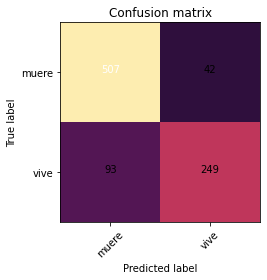

In [304]:
# Matriz de confusión
cnf_matrix = confusion_matrix(y_train, y_train_pred)

# Plot
cm_plot=plot_confusion_matrix(cnf_matrix, ['muere','vive'])

In [305]:
metric_scores(y_train, y_train_pred)

precision: 0.856
recall: 0.728
F1_score: 0.787


(0.8556701030927835, 0.7280701754385965, 0.7867298578199052)